In [1]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
import plotly.express as px
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [2]:
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)

C:\Users\loren\AppData\Local\Temp\ipykernel_44556\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_44556\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_44556\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16

In [3]:
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

There are 2245 missing values or NaNs in df_final.


In [4]:
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)

In [5]:
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)
data = data.dropna()

In [6]:
energies = ['total_aggregated','biomass', 'hard_coal', 'oil', 'geothermal', 'other', 'solar', 'waste',
       'wind', 'hydro_tot', 'gas_tot']

biomass energy plot


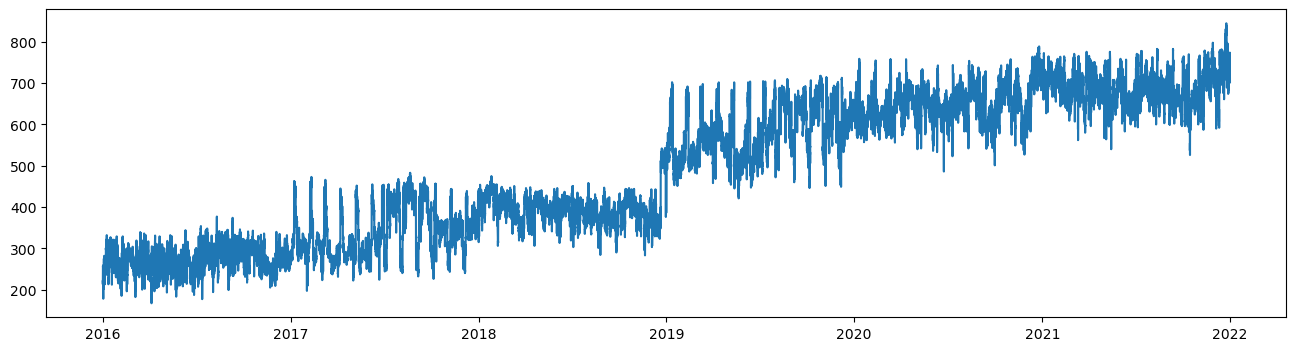

hard_coal energy plot


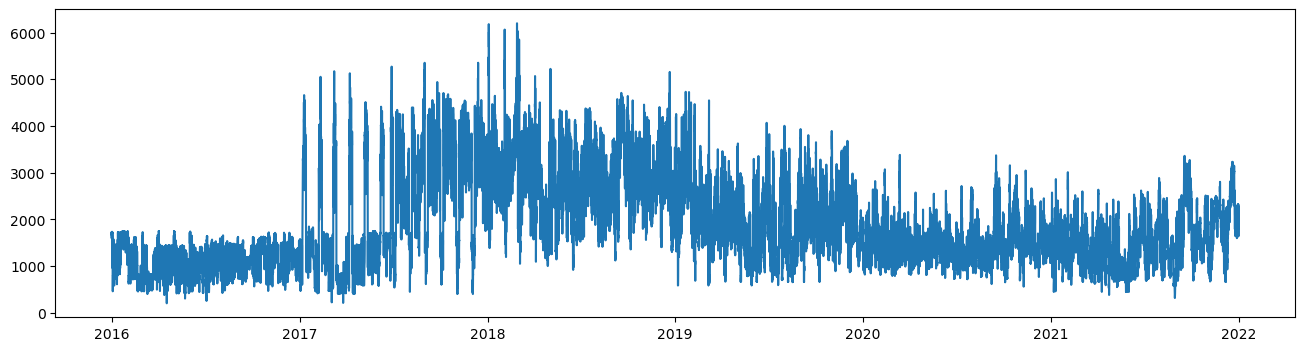

oil energy plot


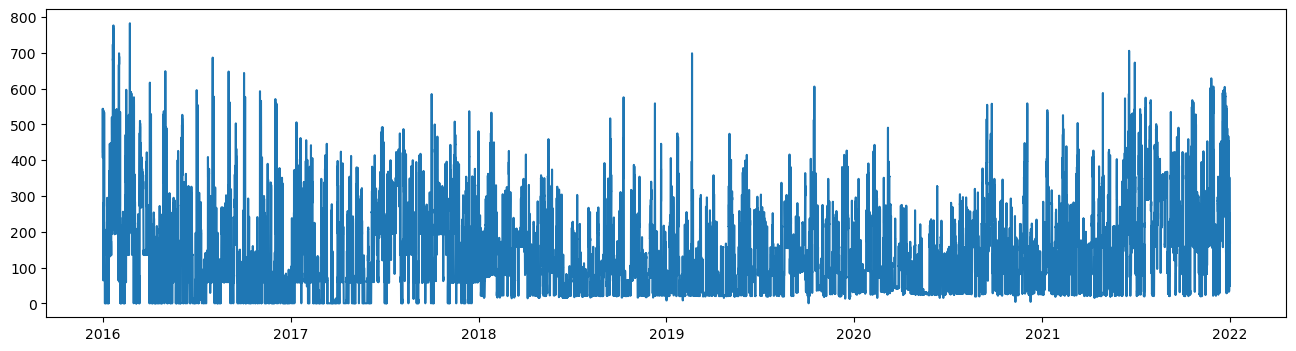

geothermal energy plot


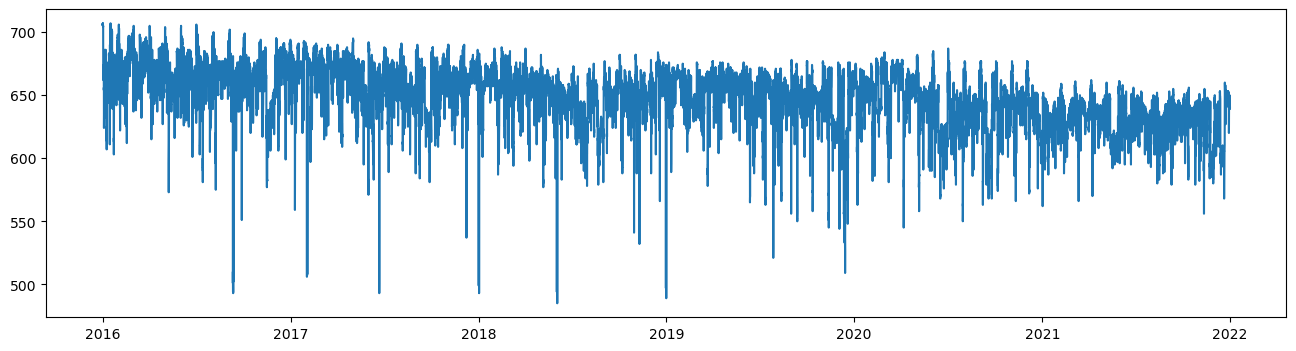

other energy plot


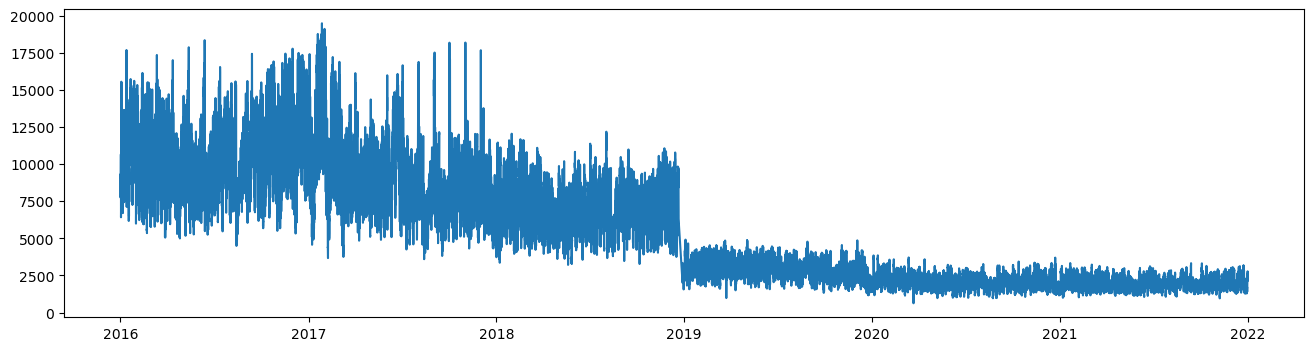

solar energy plot


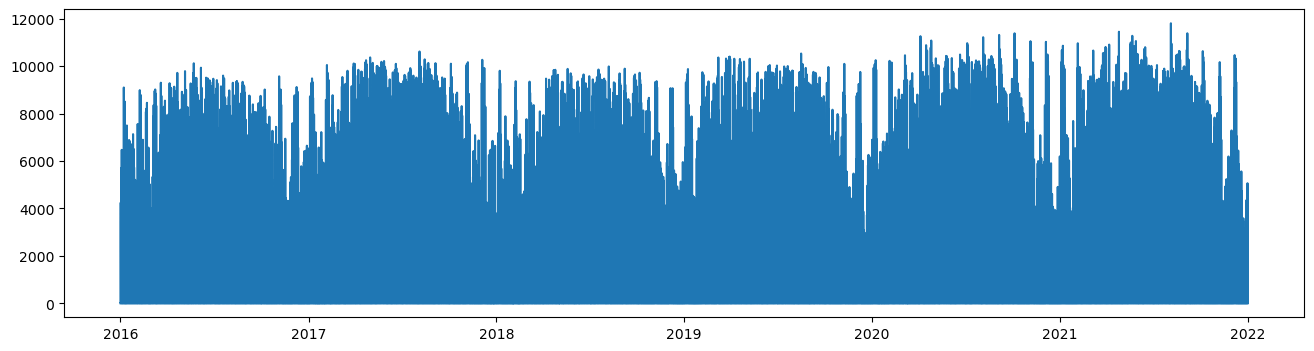

waste energy plot


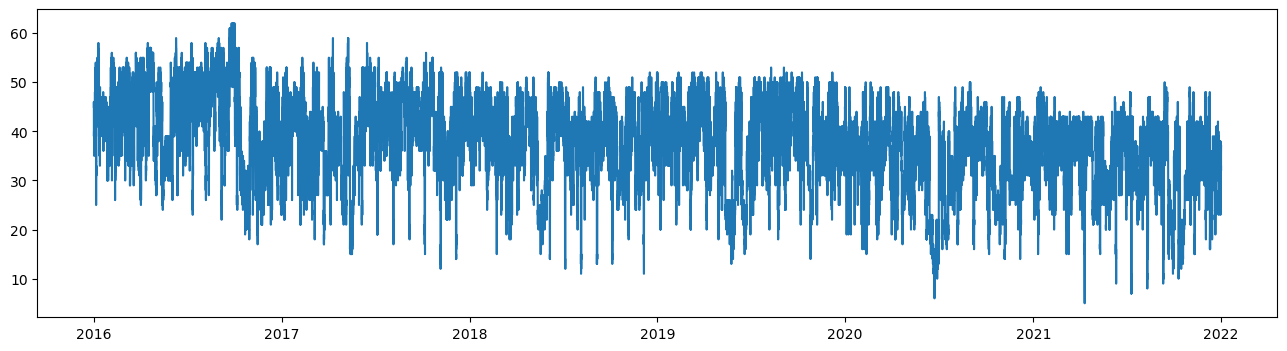

wind energy plot


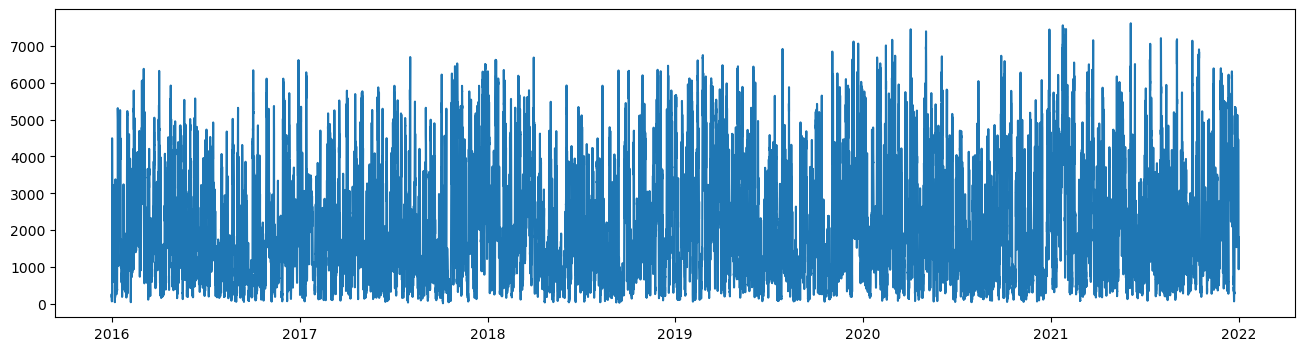

total_aggregated energy plot


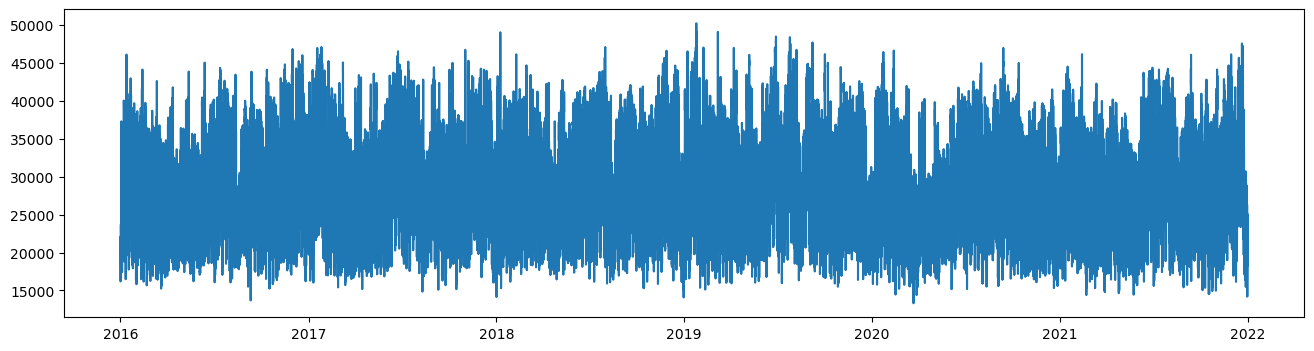

hydro_tot energy plot


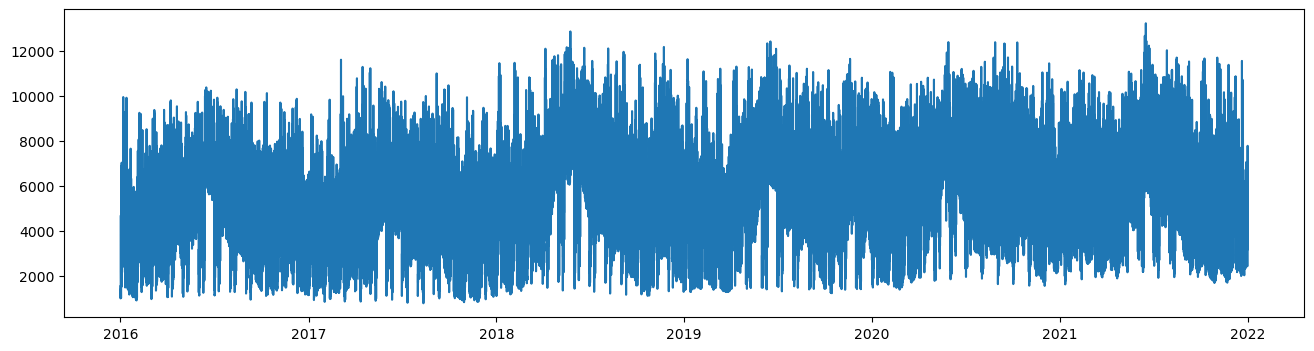

gas_tot energy plot


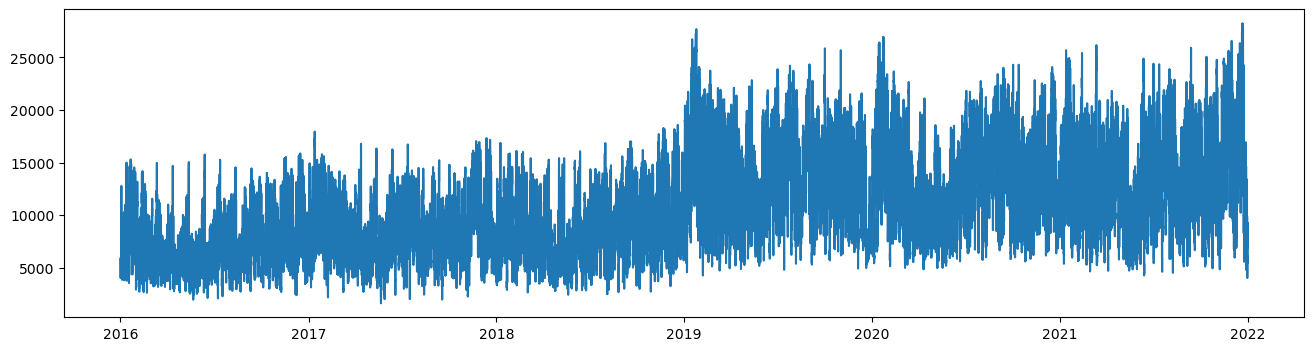

In [15]:
for energy in energies:

    plt.figure(figsize=(16,4))
    plt.plot(data[energy])
    print(f'{energy} energy plot')

    plt.show()

biomass energy plot


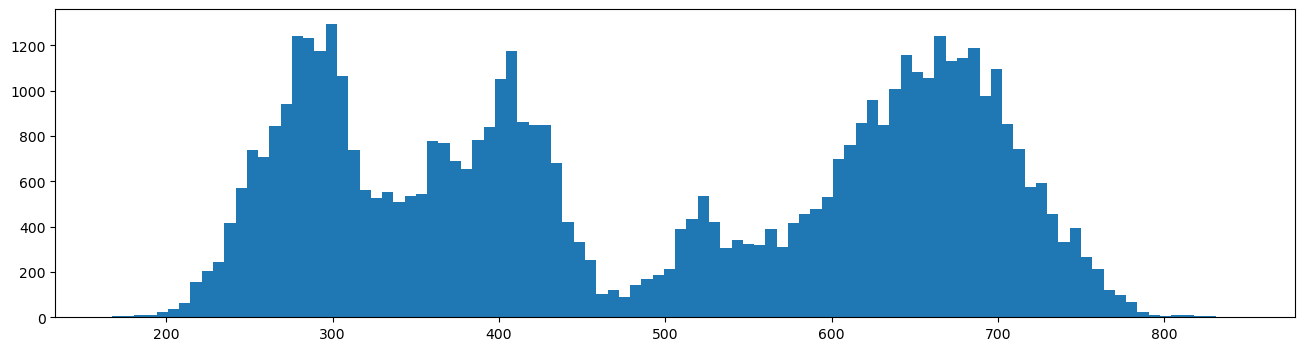

hard_coal energy plot


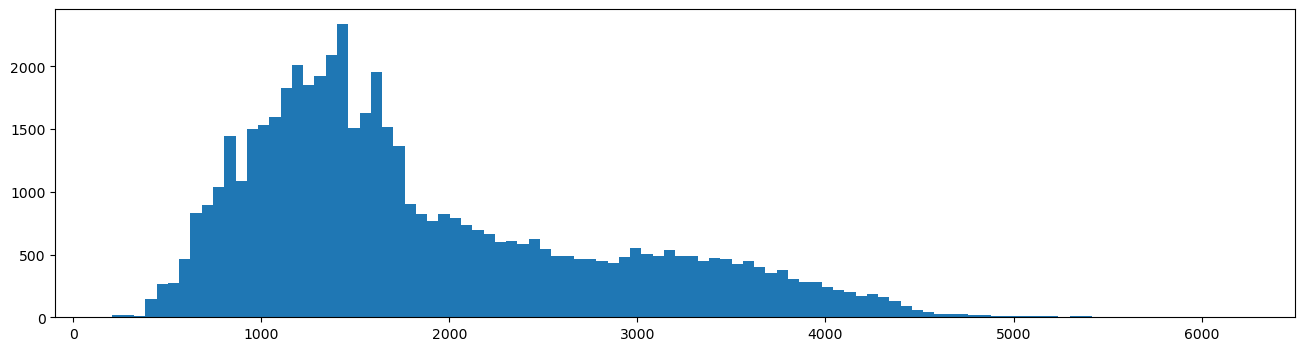

oil energy plot


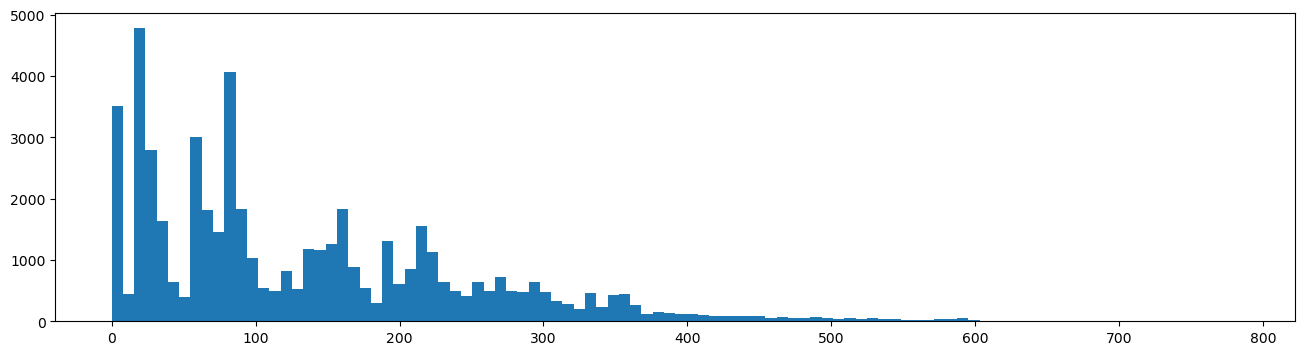

geothermal energy plot


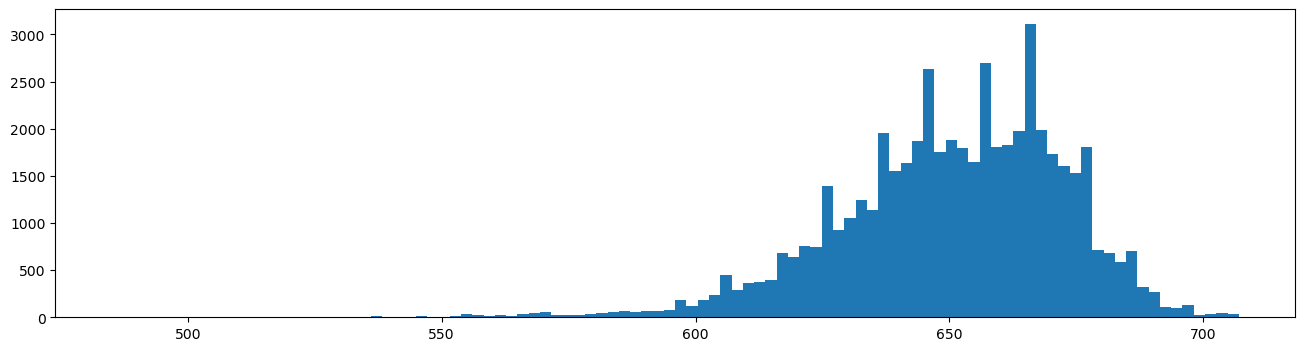

other energy plot


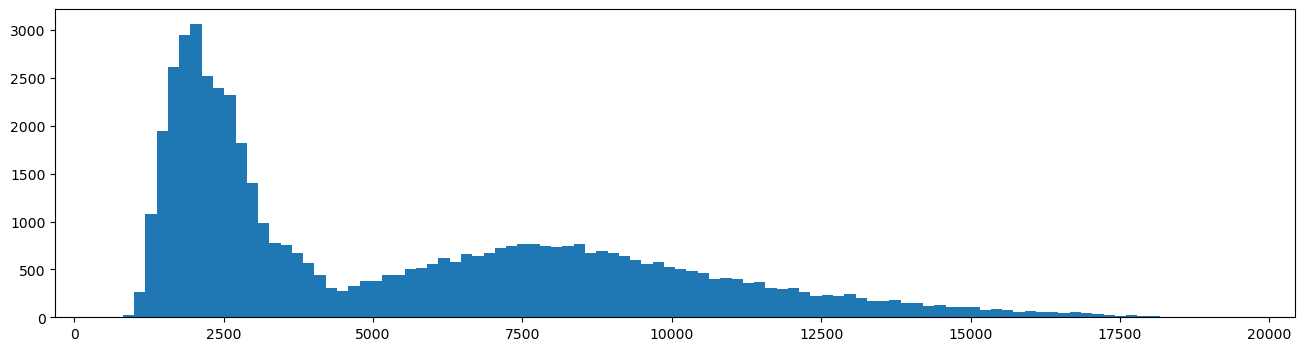

solar energy plot


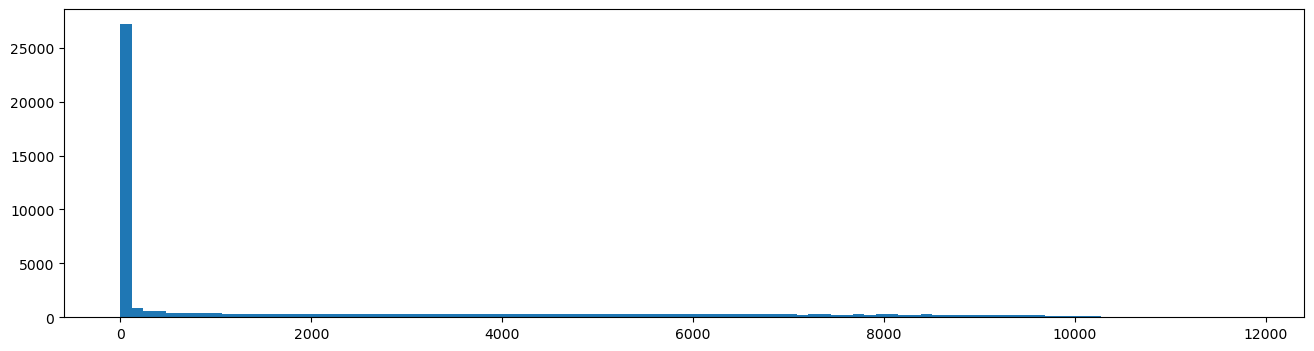

waste energy plot


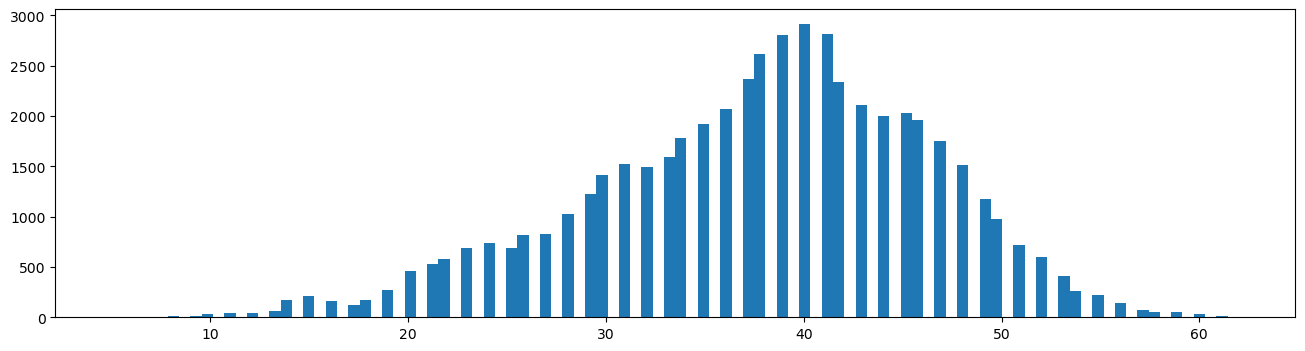

wind energy plot


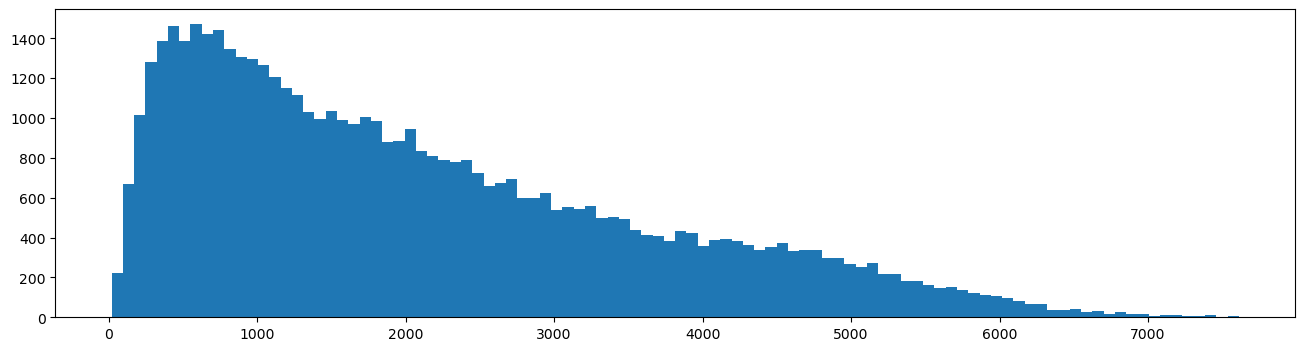

total_aggregated energy plot


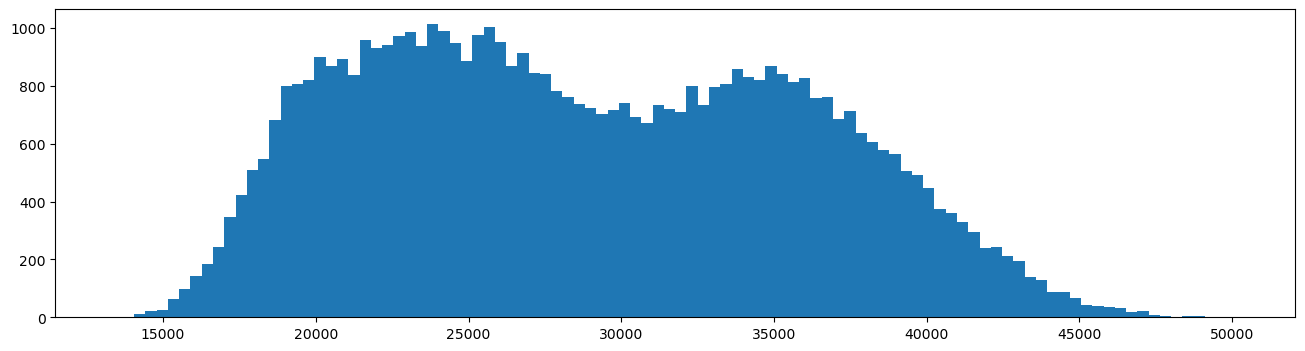

hydro_tot energy plot


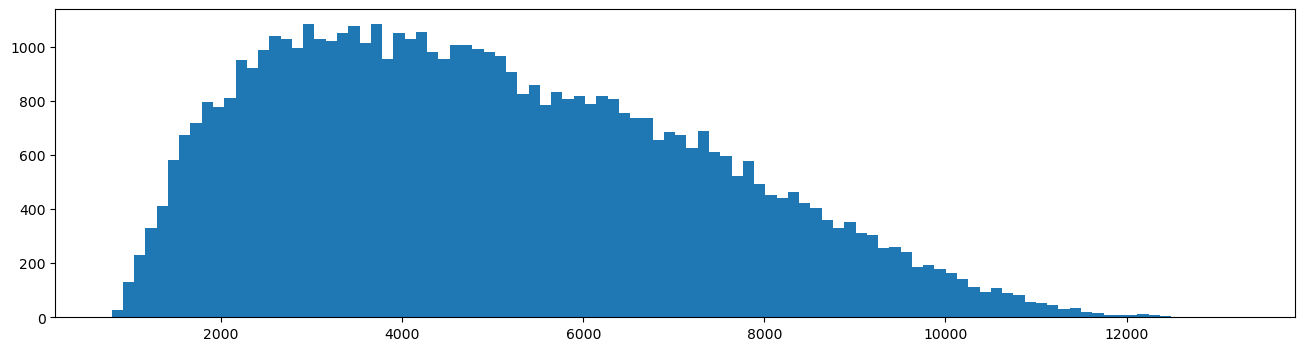

gas_tot energy plot


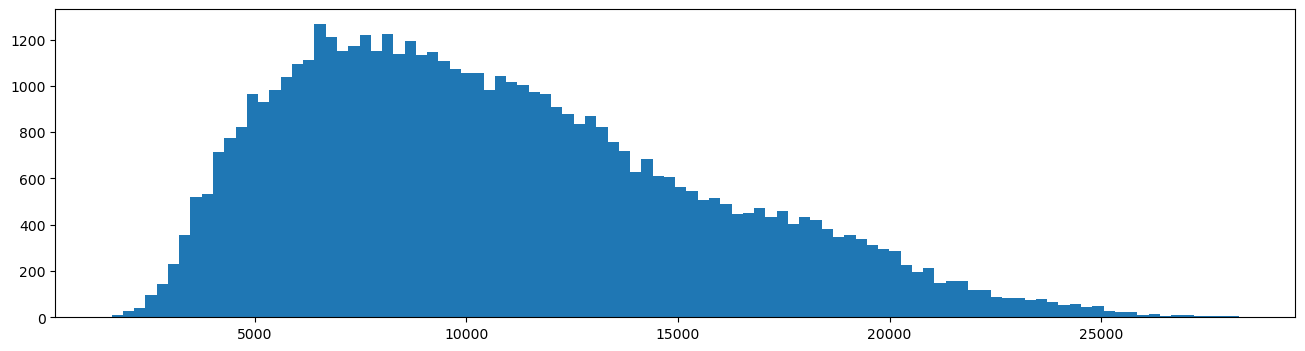

In [19]:
for energy in energies:
    plt.figure(figsize=(16,4))
    plt.hist(data[energy], bins=100)
    print(f'{energy} energy plot')

    plt.show()

In [9]:
# Facciamo test di stazionarietà classico col DF
df_stationarityTest = adfuller(data['total_aggregated'])

# Check del p-value: è decisamente sotto 0.05, quindi la serie è stazionaria, no unit root
print('ADF Statistic: %f' % df_stationarityTest[0])
print('p-value: %f' % df_stationarityTest[1])
print('Critical Values:')
for key, value in df_stationarityTest[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -20.859049
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [10]:
for energy in energies:
    # Facciamo test di stazionarietà classico col DF
    df_stationarityTest = adfuller(data[energy])

    # Check del p-value: è decisamente sotto 0.05, quindi la serie è stazionaria, no unit root
    print(f'ADF for {energy}')
    print('ADF Statistic: %f' % df_stationarityTest[0])
    print('p-value: %f' % df_stationarityTest[1])
    print('Critical Values:')
    for key, value in df_stationarityTest[4].items():
      print('\t%s: %.3f' % (key, value))

ADF for biomass
ADF Statistic: -3.569681
p-value: 0.006368
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for hard_coal
ADF Statistic: -10.327294
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for oil
ADF Statistic: -17.796542
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for geothermal
ADF Statistic: -15.111945
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for other
ADF Statistic: -5.546174
p-value: 0.000002
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for solar
ADF Statistic: -17.781844
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for waste
ADF Statistic: -15.567404
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for wind
ADF Statistic: -22.342991
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF for total_aggregated
ADF Statistic: -20.859049
p-value: 0.000000
Critical Values:
	1%: -3.430


In [11]:
from scipy.stats import shapiro, normaltest
for energy in energies:
    shapiro_test = shapiro(data[energy])
    print(f'Shapiro test for {energy}')
    print(f'Statistic: {shapiro_test.statistic}')
    print(f'P-value: {shapiro_test.pvalue}')

Shapiro test for biomass
Statistic: 0.9144197702407837
P-value: 0.0
Shapiro test for hard_coal
Statistic: 0.9151849746704102
P-value: 0.0
Shapiro test for oil
Statistic: 0.897944986820221
P-value: 0.0
Shapiro test for geothermal
Statistic: 0.9631330370903015
P-value: 0.0
Shapiro test for other
Statistic: 0.8896492123603821
P-value: 0.0
Shapiro test for solar
Statistic: 0.7401105165481567
P-value: 0.0
Shapiro test for waste
Statistic: 0.9855872392654419
P-value: 0.0
Shapiro test for wind
Statistic: 0.9253410696983337
P-value: 0.0
Shapiro test for total_aggregated
Statistic: 0.9726508855819702
P-value: 0.0
Shapiro test for hydro_tot
Statistic: 0.9708655476570129
P-value: 0.0
Shapiro test for gas_tot
Statistic: 0.9627407193183899
P-value: 0.0


c:\Users\loren\anaconda3\envs\global_packs\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [12]:
for energy in energies:
    k2, p = normaltest(data[energy])
    alpha = 0.05
    print(f"z-score for {energy} = {k2}")
    print(f"p-value for {energy} = {p}")
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected")
    else:
        print("The null hypothesis cannot be rejected")

z-score for biomass = 320951.5479269357
p-value for biomass = 0.0
The null hypothesis can be rejected
z-score for hard_coal = 5641.121505698084
p-value for hard_coal = 0.0
The null hypothesis can be rejected
z-score for oil = 9396.898508808536
p-value for oil = 0.0
The null hypothesis can be rejected
z-score for geothermal = 7811.2938322366535
p-value for geothermal = 0.0
The null hypothesis can be rejected
z-score for other = 4671.7300370049115
p-value for other = 0.0
The null hypothesis can be rejected
z-score for solar = 7573.401122064741
p-value for solar = 0.0
The null hypothesis can be rejected
z-score for waste = 1546.4976178332129
p-value for waste = 0.0
The null hypothesis can be rejected
z-score for wind = 4556.293634638406
p-value for wind = 0.0
The null hypothesis can be rejected
z-score for total_aggregated = 9778.776797289602
p-value for total_aggregated = 0.0
The null hypothesis can be rejected
z-score for hydro_tot = 2890.738102795688
p-value for hydro_tot = 0.0
The nul